## SVM / TFIDF with NGrams

### Objective

Adjust the dataset and create new features to use a SVM with a TFIDF approach with n-grams, using `char` and `word` approach.



In [1]:
import html
import re
import urllib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve, train_test_split, StratifiedKFold
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

STORAGE_PATH = './datasets/raw'
try:
    from google.colab import drive

    drive.mount('/content/drive')
    STORAGE_PATH = '/content/drive/MyDrive/xss_sqli_detector/datasets'
except:
    print('Not running on Google Colab')

XSS_SQLI_CONDENSED_WITH_FEATURES_DATASET_PATH = f'{STORAGE_PATH}/xss_sqli_condensed_with_features.csv'

Not running on Google Colab


In [2]:
df = pd.read_csv(XSS_SQLI_CONDENSED_WITH_FEATURES_DATASET_PATH)

In [3]:
# Cleanup/Categorization functions
def size_bins(payload_size: int) -> str:
    if 0 < payload_size < 500:
        return "0_500"
    elif 500 <= payload_size < 1000:
        return "500_1000"
    elif 1000 <= payload_size < 1500:
        return "1000_1500"
    elif 1500 <= payload_size < 2000:
        return "1500_2000"
    elif 2000 <= payload_size < 2500:
        return "2000_2500"
    elif 2500 <= payload_size < 3000:
        return "2500_3000"
    elif 3000 <= payload_size < 3500:
        return "3000_3500"
    else:
        return ">3500"


def size_bins_number(payload_size: int) -> int:
    if 0 < payload_size < 500:
        return 0
    elif 500 <= payload_size < 1000:
        return 1
    elif 1000 <= payload_size < 1500:
        return 2
    elif 1500 <= payload_size < 2000:
        return 3
    elif 2000 <= payload_size < 2500:
        return 4
    elif 2500 <= payload_size < 3000:
        return 5
    elif 3000 <= payload_size < 3500:
        return 6
    else:
        return 7


def canonicalize_text(s: str) -> str:
    s = s.strip().lower()
    s = urllib.parse.unquote(s)
    s = html.unescape(s)
    s = re.sub(r"\s+", " ", s)
    return s

In [4]:
# Remove unused columns

df.drop(columns=['Unnamed: 0', 'contains_script_tag', 'contains_cookie_related', 'contains_xss_ascii_malformed',
                 'contains_sql_operators', 'contains_sql_functions', 'contains_sql_tautologies', 'special_chars_count',
                 'http_word_count', 'reserved_sql_words_count', 'reserved_js_words_count', 'reserved_web_sink_count',
                 'detected_by_libinjection'], inplace=True)

df['payload_bin'] = df['payload_length'].apply(size_bins)
df['payload_bin_number'] = df['payload_length'].apply(size_bins_number)
df['payload'].astype(str).map(canonicalize_text)

df.drop_duplicates()

,payload,label,attack_label,type,payload_length,label_type,payload_bin,payload_bin_number
0,"""1%"""" ) waitfor delay '0:0:5'--""",1,SQLi,Malicious,35,1,0_500,0
1,"<form onmouseup=""alert(1)"">test</form>",2,XSS,Malicious,38,1,0_500,0
2,your skin looks lovely,0,normal,Benign,22,0,0_500,0
3,xubder rvy6crzr34rulq71yfvscl740klx2d0 s6so06r...,1,SQLi,Malicious,983,1,500_1000,1
4,åŒã˜ãƒ–ãƒ©ãƒ³ãƒ‰ã®æ™‚è¨ˆã‚’è³¼å…¥ã—ã€ãƒ•ã...,0,normal,Benign,251,0,0_500,0
...,...,...,...,...,...,...,...,...
273699,produto=%22%3E'%3E%3CSCRIPT%3Ealert(String.fro...,1,XSS,Malicious,90,1,0_500,0
273700,m=%22%3E'%3E%3CSCRIPT%3Ealert(String.fromCharC...,1,XSS,Malicious,84,1,0_500,0
273701,q=%3Cscript%3Ealert%28%22m%22%29%3C/script%3E,1,XSS,Malicious,45,1,0_500,0
273702,Search=%22%3E'%3E%3CSCRIPT%20SRC=http://br.zon...,1,XSS,Malicious,273,1,0_500,0


In [5]:
df['payload_bin'].value_counts()

payload_bin
0_500        207013
500_1000      61812
1000_1500      2315
1500_2000       880
>3500           733
2000_2500       478
2500_3000       277
3000_3500       196
Name: count, dtype: int64

In [6]:
df[df['payload_bin_number'] <= 6]['type'].value_counts()

type
Malicious    152412
Benign       120559
Name: count, dtype: int64

In [7]:
df[df['payload_bin_number'] <= 5]['type'].value_counts()


type
Malicious    152403
Benign       120372
Name: count, dtype: int64

In [8]:
df[df['payload_bin_number'] <= 2]['type'].value_counts()


type
Malicious    152363
Benign       118777
Name: count, dtype: int64

In [5]:
filtered_df = df[df['payload_bin_number'] <= 2].copy()
df = None

In [6]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271140 entries, 0 to 273703
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   payload             271140 non-null  object
 1   label               271140 non-null  int64 
 2   attack_label        271140 non-null  object
 3   type                271140 non-null  object
 4   payload_length      271140 non-null  int64 
 5   label_type          271140 non-null  int64 
 6   payload_bin         271140 non-null  object
 7   payload_bin_number  271140 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 18.6+ MB


In [7]:
X = filtered_df["payload"].astype(str).values
y = filtered_df["label_type"].values

num_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [12]:
char_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 7), min_df=5, max_df=0.85, sublinear_tf=True,
                                  strip_accents=None)
word_vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1, 3), min_df=5, max_df=0.85,
                                  token_pattern=r'\b\w+\b|<[^>]+>|[!"#$%&\'()*+,\-./:;<=>?@\[\]\\^—`\{\|\}~]')

svm_pipe = Pipeline([
    ("feats", FeatureUnion([("char_tfid", char_vectorizer), ("word_tfid", word_vectorizer)])),
    ("svm", LinearSVC(C=1.0, class_weight="balanced", verbose=5, max_iter=5000))
], verbose=True)

svm_pipe.fit(X_train, y_train)


[Pipeline] ............. (step 1 of 2) Processing feats, total= 5.2min
[LibLinear]......*
optimization finished, #iter = 61
Objective value = -1693.528872
nSV = 23085
[Pipeline] ............... (step 2 of 2) Processing svm, total=  28.7s


Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('char_tfid',
                                                 TfidfVectorizer(analyzer='char',
                                                                 max_df=0.85,
                                                                 min_df=5,
                                                                 ngram_range=(2,
                                                                              7),
                                                                 sublinear_tf=True)),
                                                ('word_tfid',
                                                 TfidfVectorizer(max_df=0.85,
                                                                 min_df=5,
                                                                 ngram_range=(1,
                                                                              3),
                                                                 token_pattern='\\b\\w+\\b|<[^>]+>|[!"#$%&\\\'()*+,\\-./:;<=>?@\\[\\]\\\\^—`\\{\\|\\}~]'))])),
                ('svm',
                 LinearSVC(class_weight='balanced', max_iter=5000, verbose=5))],
         verbose=True)

In [18]:
y_pred = svm_pipe.predict(X_test)
print("SVM report:\n", classification_report(y_test, y_pred, digits=3))

SVM report:
               precision    recall  f1-score   support

           0      0.995     0.998     0.996     23755
           1      0.999     0.996     0.997     30473

    accuracy                          0.997     54228
   macro avg      0.997     0.997     0.997     54228
weighted avg      0.997     0.997     0.997     54228



In [24]:
print("This is malicious", svm_pipe.predict(
    [""""<p>Este es un parrafo en html</p> y ahora trae un suculento xss donde este texto es algo grande o suficientemente gigante como para evadir el modelo, será cierto eso? o podré seguir escribiendo texto acá? <script>alert(1)</script>"""]))


This is benign [1]


In [21]:
print("This is malicious", svm_pipe.predict(["<a onblur=alert(1) tabindex=1 id=x></a><input autofocus>"]))

This is malicious [1]


In [29]:
print("This is benign???? (inserted some bad code)", svm_pipe.predict(
    ["""Hola! Me da gusto saber de ti y de todos los siguientes: Juan, Paco, Pedro y este es otro texto bien Paquito y el t0x1c en l33tc0d3 <script>alert('XSS3')</script>"""]))

This is benign???? (inserted some bad code) [1]


In [8]:
## Save/Load Functions
def save_model(path: str, pipeline: Pipeline, metadata: dict) -> None:
    joblib.dump({"model": pipeline, "metadata": metadata}, path, compress=("lzma", 3))
    print(f"Model saved in : {path}")


def load_model(path: str):
    return joblib.load(path)


In [9]:
# Save/load the trained model
model_path = "models/svm_tfidf_linearSVC.joblib"

# metadata = {
#     "sklearn_version": sk_version,
#     "created_at": time.strftime("%Y-%m-%d %H:%M"),
#     "model_type": "Pipeline(FeatureUnion(TfidfVectorizer char + word) -> LinearSVC)",
#     "classes_": svm_pipe.named_steps["svm"].classes_.tolist(),
#     "params": svm_pipe.get_params(deep=False),
# }
# save_model(path=model_path, pipeline=svm_pipe, metadata=metadata)

# Load the trained model
loaded_model = load_model(path=model_path)

# temporary hack

svm_pipe = loaded_model["model"]



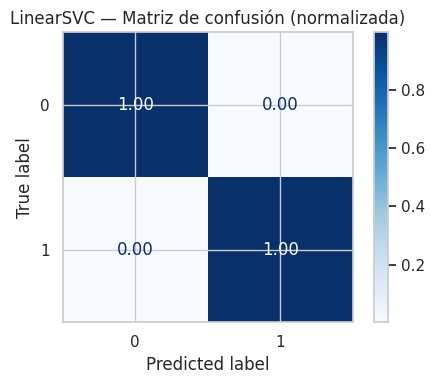

In [37]:
# Plotting data
sns.set_theme(context="notebook", style="whitegrid")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize="true", values_format=".2f", cmap="Blues", ax=ax
)
ax.set_title("LinearSVC — Matriz de confusión (normalizada)")
plt.tight_layout()


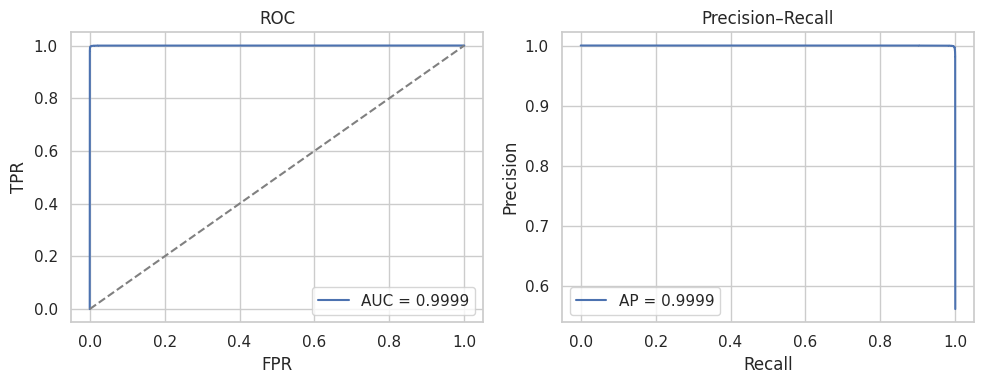

In [40]:
# --- 2) Curvas ROC y PR usando decision_function---
scores = svm_pipe.decision_function(X_test)  # márgenes
fpr, tpr, _ = roc_curve(y_test, scores, pos_label=1)
roc_auc = roc_auc_score(y_test, scores)
prec, rec, _ = precision_recall_curve(y_test, scores, pos_label=1)
ap = average_precision_score(y_test, scores)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
axes[0].plot([0, 1], [0, 1], "--", color="gray")
axes[0].set(title="ROC", xlabel="FPR", ylabel="TPR");
axes[0].legend()

axes[1].plot(rec, prec, label=f"AP = {ap:.4f}")
axes[1].set(title="Precision–Recall", xlabel="Recall", ylabel="Precision");
axes[1].legend()
plt.tight_layout()

[Pipeline] ............. (step 1 of 2) Processing feats, total=  42.0s
[LibLinear]....*
optimization finished, #iter = 47
Objective value = -433.309377
nSV = 6191
[Pipeline] ............... (step 2 of 2) Processing svm, total=   2.3s
[Pipeline] ............. (step 1 of 2) Processing feats, total= 1.6min
[LibLinear].....*
optimization finished, #iter = 54
Objective value = -796.285693
nSV = 11408
[Pipeline] ............... (step 2 of 2) Processing svm, total=   7.8s
[Pipeline] ............. (step 1 of 2) Processing feats, total= 2.6min
[LibLinear].....*
optimization finished, #iter = 54
Objective value = -1058.558613
nSV = 15040
[Pipeline] ............... (step 2 of 2) Processing svm, total=  11.8s
[Pipeline] ............. (step 1 of 2) Processing feats, total= 3.7min
[LibLinear].....*
optimization finished, #iter = 54
Objective value = -1298.088303
nSV = 18218
[Pipeline] ............... (step 2 of 2) Processing svm, total=  17.2s
[Pipeline] ............. (step 1 of 2) Processing feats,

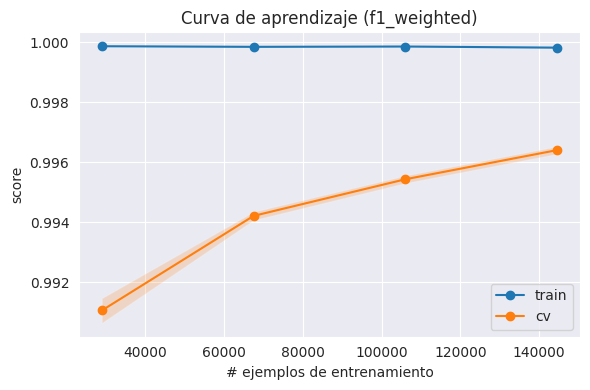

In [10]:
# --- 3) Curva de aprendizaje (¿sobre-ajuste/sub-ajuste y beneficio de más datos?) ---
# Métrica: f1_weighted (útil con clases desbalanceadas)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(
    svm_pipe, X_train, y_train,
    train_sizes=np.linspace(0.2, 1.0, 4),
    cv=cv, n_jobs=2, scoring="f1_weighted"
)

train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
valid_mean, valid_std = valid_scores.mean(axis=1), valid_scores.std(axis=1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(train_sizes, train_mean, "o-", label="train")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=.2)
ax.plot(train_sizes, valid_mean, "o-", label="cv")
ax.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=.2)
ax.set(title="Curva de aprendizaje (f1_weighted)", xlabel="# ejemplos de entrenamiento", ylabel="score")
ax.legend()
plt.tight_layout()